In [1]:
import os
import pathlib
import glob
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [9]:
file_path = "./train"

In [10]:
files_name = os.listdir(file_path)

In [11]:
for i in range(len(files_name)):
    files_name[i] = file_path + "/" + files_name[i]

In [5]:
files_name[:10]

['./train/cat.9438.jpg',
 './train/cat.4021.jpg',
 './train/dog.3737.jpg',
 './train/cat.11970.jpg',
 './train/cat.11168.jpg',
 './train/cat.2292.jpg',
 './train/dog.5223.jpg',
 './train/dog.10969.jpg',
 './train/dog.11896.jpg',
 './train/dog.7701.jpg']

In [12]:
len(files_name)

25004

In [13]:
files_name[0].split("/")[2].split(".")[0]

'cat'

In [14]:
d = {"cat":0,
     "dog":1}
binary_cat = []
for i in range(len(files_name)):
    a = files_name[i].split("/")[2].split(".")[0]
    binary_cat.append(d[a])

In [15]:
binary_cat[:10]

[0, 0, 1, 0, 0, 0, 1, 1, 1, 1]

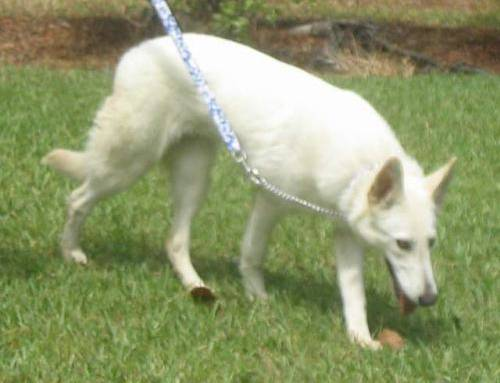

In [16]:
import IPython.display as display
display.display(display.Image(files_name[2]))

In [17]:
len(binary_cat)

25004

In [18]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(files_name, binary_cat, test_size=0.3)
len(x_train)

17502

In [25]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label
image_label_ds_train = ds_train.map(load_and_preprocess_from_path_label)
image_label_ds_train

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [26]:
ds_test = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label
image_label_ds_test = ds_test.map(load_and_preprocess_from_path_label)
image_label_ds_test

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [27]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds_train = image_label_ds_train.shuffle(buffer_size=len(x_train))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)

ds_test = image_label_ds_test.shuffle(buffer_size=len(x_valid))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)


In [28]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False


model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation = 'sigmoid')])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
steps_per_epoch=tf.math.ceil(len(x_train)/BATCH_SIZE).numpy()
history = model.fit(ds_train, epochs=15, steps_per_epoch=steps_per_epoch)

Train for 547.0 steps
Epoch 1/15
547/547 [==============================] - 371s 678ms/step - loss: 0.1488 - accuracy: 0.9403
Epoch 2/15
547/547 [==============================] - 68s 124ms/step - loss: 0.1116 - accuracy: 0.9557
Epoch 3/15
547/547 [==============================] - 68s 124ms/step - loss: 0.1035 - accuracy: 0.9580
Epoch 4/15
547/547 [==============================] - 68s 124ms/step - loss: 0.0942 - accuracy: 0.9630
Epoch 5/15
547/547 [==============================] - 67s 122ms/step - loss: 0.0930 - accuracy: 0.9636
Epoch 6/15
547/547 [==============================] - 65s 119ms/step - loss: 0.0917 - accuracy: 0.9640
Epoch 7/15
547/547 [==============================] - 63s 115ms/step - loss: 0.1045 - accuracy: 0.9592
Epoch 8/15
547/547 [==============================] - 59s 108ms/step - loss: 0.0893 - accuracy: 0.9664
Epoch 9/15
547/547 [==============================] - 52s 94ms/step - loss: 0.0938 - accuracy: 0.9634
Epoch 10/15
547/547 [==============================

In [36]:
steps_per_epoch=tf.math.ceil(len(x_valid)/BATCH_SIZE).numpy()
model.evaluate(ds_test, steps=steps_per_epoch)

235/235 [==============================] - 149s 635ms/step - loss: 0.1079 - accuracy: 0.9644


[0.10789985329635997, 0.9643617]